# Evaluating DeBERTaV3 with the Nonparametric Analysis
---
*A nonparametric analysis of hyperparameter search for fine-tuning DeBERTa and DeBERTaV3*

For more background, see the notebook [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb) or our paper: [**Show Your Work with Confidence: Confidence Bands for Tuning Curves**](https://arxiv.org/abs/2311.09480).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np

from opda import nonparametric
import opda.random

# constants

evaluations = {
    "matched": {
        "name": "MultiNLI-m",
    },
    "mismatched": {
        "name": "MultiNLI-mm",
    },
}

models = {
    "deberta-base": {
        "name": "DeBERTa",
        "style": {"linestyle": "-", "color": "#FFB000"},
    },
    "deberta-v3-base": {
        "name": "DeBERTaV3",
        "style": {"linestyle": "--", "color": "#648FFF"},
    },
}


# experimental settings

evaluation = "matched"
model = "deberta-v3-base"
band = "ld_highest_density"

sample_sizes = [6, 20, 34, 48]
n = sample_sizes[-1]  # Later analyses assume n == sample_sizes[-1]
ns_grid = np.linspace(1, n, num=10_000)

y_min = 0.
y_max = 1.

confidence = 0.80


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## The DeBERTa Model Family

One approach to natural language processing takes a neural network pretrained with raw text and then fine-tunes it on labeled data. [DeBERTa](https://github.com/microsoft/DeBERTa) offers one such pretrained model, with two major versions: *DeBERTa* [(He et al., 2021)](https://arxiv.org/abs/2006.03654) and *DeBERTaV3* [(He et al., 2023)](https://arxiv.org/abs/2111.09543).

Despite sharing their name, DeBERTa and DeBERTaV3 have significant differences. For example, DeBERTa is trained with a generative masked-language modeling objective [(Devlin et al., 2018)](https://arxiv.org/abs/1810.04805), while DeBERTaV3 uses the discriminative ELECTRA pretraining [(Clark et al., 2020)](https://arxiv.org/abs/2003.10555).

Both models have a number of hyperparameters to set when fine-tuning them. We can investigate these models individually and compare them to each other using optimal design analysis (OPDA).

## Experimental Design

In our case study, we compare fine-tuning two pretrained models, DeBERTa and DeBERTaV3, for natural language inference (NLI) on the [MultiNLI dataset](https://cims.nyu.edu/~sbowman/multinli/) [(Adina et al., 2018)](https://arxiv.org/abs/1704.05426).

When assessing models with OPDA, one must first define the hyperparameter search distribution and then sample and evaluate hyperparameters from it. Since DeBERTa and DeBERTaV3 share the same hyperparameters for fine-tuning, we used the same search distribution for both:

$$
\begin{align*}
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(16, 64) \\
  \mathtt{num}\_\mathtt{epochs} &\sim \operatorname{DiscreteUniform}( 1,  4) \\
  \mathtt{warmup}\_\mathtt{proportion} &\sim \operatorname{Uniform}(0, 0.6) \\
  \mathtt{learning}\_\mathtt{rate} &\sim \operatorname{LogUniform}(10^{-6}, 10^{-3}) \\
  \mathtt{dropout} &\sim \operatorname{Uniform}(0, 0.3) \\
\end{align*}
$$

where $\mathtt{warmup}\_\mathtt{proportion}$ is the number of warmup steps as a proportion of the first epoch. 

We fine-tuned both DeBERTa and DeBERTaV3 on MultiNLI using 1,024 hyperparameter settings sampled from this search distribution. MultiNLI has two validation sets: matched (same domains as training) and mismatched (different domains from training). Each fine-tuned model was evaluated on both. Thus, for each model and validation set we have 1,024 accuracy numbers&mdash;one for each sampled set of hyperparameters.

In [2]:
# load the data
model_to_evaluation_to_ys = {}
for model_ in models:
    for evaluation_ in evaluations:
        ys = []
        with open(f"../../data/deberta/{model_}.results.jsonl") as f_in:
            for ln in f_in:
                ex = json.loads(ln)
                ys.append(max(
                    score
                    for _, score in ex["learning_curves"][evaluation_]
                ))
        if model_ not in model_to_evaluation_to_ys:
            model_to_evaluation_to_ys[model_] = {}
        model_to_evaluation_to_ys[model_][evaluation_] = np.array(ys)

total_samples = 1_024
for model_ in models:
    for evaluation_ in evaluations:
        if len(model_to_evaluation_to_ys[model_][evaluation_]) != total_samples:
            raise RuntimeError(
                "The experiment data does not contain the correct"
                " number of examples.",
            )

## Comparing Against a Baseline

Suppose we wanted to compare fine-tuning DeBERTa and DeBERTaV3 for NLI using MultiNLI [(Adina et al., 2018)](https://arxiv.org/abs/1704.05426). OPDA recommends that we identify the hyperparameters, define a search distribution, and then analyze the tuning curves associated with this search distribution. Assume we used the search distribution defined above:

$$
\begin{align*}
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(16, 64) \\
  \mathtt{num}\_\mathtt{epochs} &\sim \operatorname{DiscreteUniform}( 1,  4) \\
  \mathtt{warmup}\_\mathtt{proportion} &\sim \operatorname{Uniform}(0, 0.6) \\
  \mathtt{learning}\_\mathtt{rate} &\sim \operatorname{LogUniform}(10^{-6}, 10^{-3}) \\
  \mathtt{dropout} &\sim \operatorname{Uniform}(0, 0.3) \\
\end{align*}
$$

where $\mathtt{warmup}\_\mathtt{proportion}$ is the number of warmup steps as a proportion of the first epoch. 

If our aim is to evaluate DeBERTaV3, then one [rule of thumb for picking the number of search iterations](./choosing-a-sample-size-for-the-nonparametric-analysis.ipynb) is to determine how many iterations we expect model users to perform and then multiply that by at least 6.25 (if we plan to use 80% confidence bands). So, if a typical model user will perform 6-8 search iterations, we'll use at least 37.5 to 50 to construct the tuning curve. For this analysis, we'll use 48.

Since the nonparametric bands from OPDA hold simultaneously, they provide quite a strong guarantee, so we'll use an 80% confidence level for constructing our bands.

### Evaluating a Single Model

To evaluate a single model, we construct [the tuning curve](../theory/formalizing-the-problem.ipynb) with confidence bands. Potential users can then read the cost-benefit trade-off from these plots and determine whether the model achieves sufficient performance for their application and within their computational budget. For DeBERtaV3 on MultiNLI, the tuning curves look as follows:

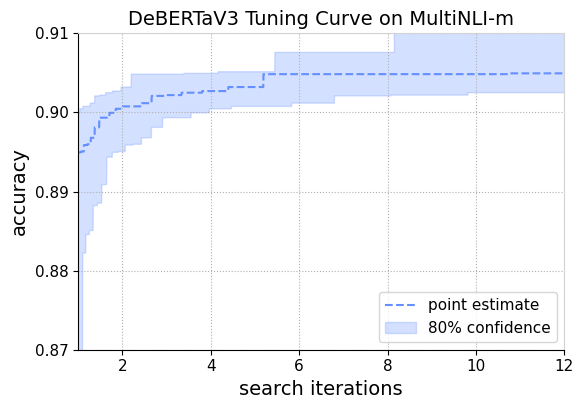

In [3]:
# Subsample the data to obtain a sample of size n.
ys = generator.choice(
    model_to_evaluation_to_ys[model][evaluation],
    size=n,
    replace=False,
)

# Construct the confidence bands.
lower_cdf, point_cdf, upper_cdf =\
    nonparametric.EmpiricalDistribution.confidence_bands(
        ys,
        confidence=confidence,
        a=y_min,
        b=y_max,
        method=band,
    )

# Plot the confidence bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.25))

ax.plot(
    ns_grid,
    point_cdf.quantile_tuning_curve(ns_grid),
    label="point estimate",
    **models[model]["style"],
)
ax.fill_between(
    ns_grid,
    upper_cdf.quantile_tuning_curve(ns_grid),
    lower_cdf.quantile_tuning_curve(ns_grid),
    alpha=0.275,
    label=f"{confidence * 100:.0f}% confidence",
    color=models[model]["style"]["color"],
)

# Format the plot.
ax.set_xlim(1, n // 4)
ax.set_ylim(0.87, 0.91)
ax.set_yticks(np.linspace(0.87, 0.91, num=5))
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")
ax.legend(loc="lower right")
ax.set_xlabel("search iterations")
ax.set_ylabel("accuracy")
ax.set_title(
    f'{models[model]["name"]} Tuning Curve'
    f' on {evaluations[evaluation]["name"]}',
)

fig.tight_layout()

plt.show()

Thus, we see that with 48 search iterations, we can bound the tuning curve fairly tightly up to about 8 search iterations. Below, we visualize what the tuning curve bounds look like for various sample sizes and both the matched and mismatched MultiNLI test sets:

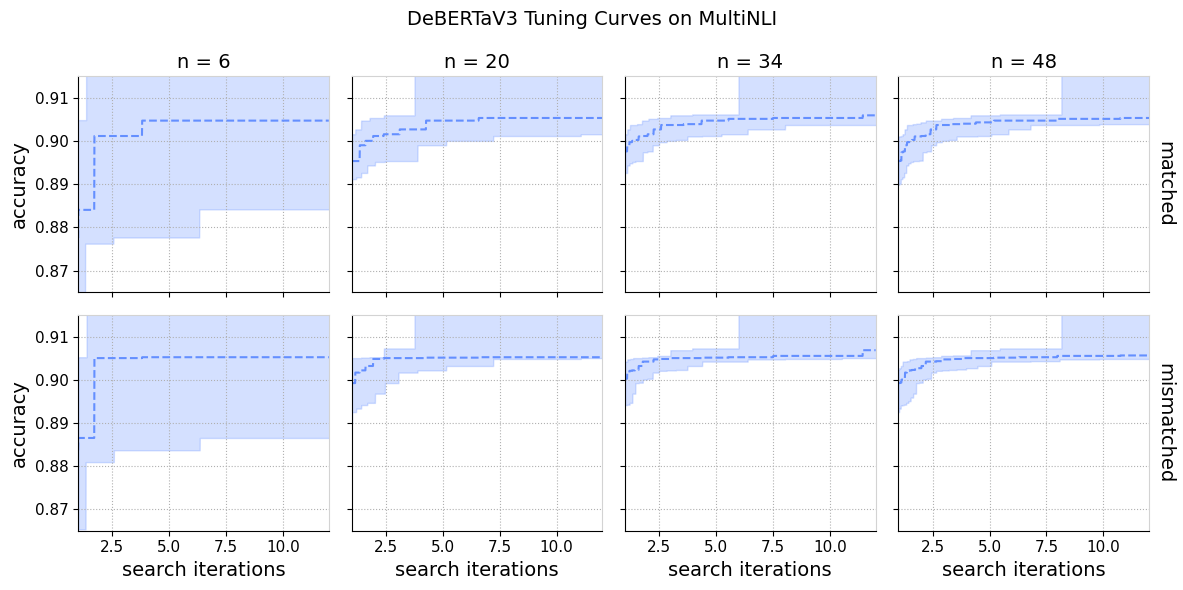

In [4]:
# Choose indices to subsample the data and obtain a sample of size
# sample_size_.
idxs = generator.choice(total_samples, size=n, replace=False)

fig, axes = plt.subplots(
    nrows=2,
    ncols=len(sample_sizes),
    sharex=True,
    sharey="row",
    figsize=(12, 6),
)
for j, sample_size_ in enumerate(sample_sizes):
    for i, evaluation_ in enumerate(evaluations):
        ys = model_to_evaluation_to_ys[model][evaluation_][
            idxs[:sample_size_]
        ]

        # Construct the confidence bands.
        lower_cdf, point_cdf, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band,
            )

        # Plot the confidence bands.
        axes[i, j].plot(
            ns_grid,
            point_cdf.quantile_tuning_curve(ns_grid),
            **models[model]["style"],
        )
        axes[i, j].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.275,
            color=models[model]["style"]["color"],
        )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel("search iterations")
    axes[0, j].set_title(f"n = {sample_size_}")

for i, evaluation_ in enumerate(evaluations):
    axes[i, 0].set_ylabel("accuracy")
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(evaluation_, labelpad=18, rotation=270)

for i in range(len(evaluations)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

fig.suptitle(
    f'{models[model]["name"]} Tuning Curves on MultiNLI',
)

fig.tight_layout()

plt.show()

We see the main effect of increasing sample size is to shift over the point at which the upper confidence band jumps to the upper bound on performance. Increasing the sample size does tend to narrow the band as well; however, the effect is not very noticeable on DeBERTaV3.

### Comparing Two Models

Beyond evaluating a single model, we may also want to compare two models. To accomplish this task, we can plot their tuning curves with confidence bands side-by-side:

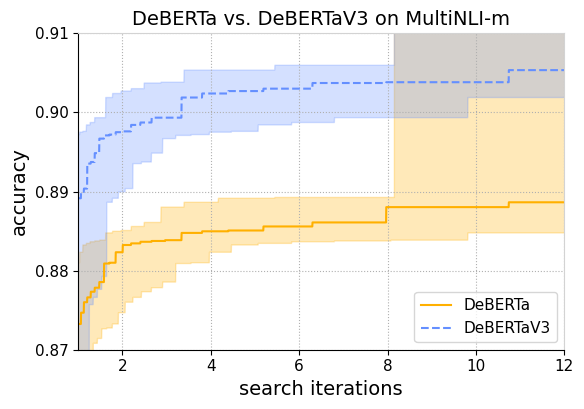

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.25))
for model_ in models:
    # Subsample the data to obtain a sample of size n.
    ys = generator.choice(
        model_to_evaluation_to_ys[model_][evaluation],
        size=n,
        replace=False,
    )

    # Construct the confidence bands.
    lower_cdf, point_cdf, upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys,
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    # Plot the confidence bands.
    ax.plot(
        ns_grid,
        point_cdf.quantile_tuning_curve(ns_grid),
        label=models[model_]["name"],
        **models[model_]["style"],
    )
    ax.fill_between(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        lower_cdf.quantile_tuning_curve(ns_grid),
        alpha=0.275,
        color=models[model_]["style"]["color"],
    )

# Format the plot.
ax.set_xlim(1, n // 4)
ax.set_ylim(0.87, 0.91)
ax.set_yticks(np.linspace(0.87, 0.91, num=5))
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")
ax.legend(loc="lower right")
ax.set_xlabel("search iterations")
ax.set_ylabel("accuracy")
ax.set_title(
    f'DeBERTa vs. DeBERTaV3 on {evaluations[evaluation]["name"]}',
)

fig.tight_layout()

plt.show()

In general, it's tempting to require that there's no overlap between the confidence bands before concluding that one model is better than the other; however, this criterion is too conservative. Inspired by [Minka (2002)](https://tminka.github.io/papers/minka-errorbars.pdf), one could use the following guidelines: the evidence for an improvement is *weak* if one point estimate is excluded by the other's confidence bands, *fair* if each point estimate is excluded by the other's confidence bands, and *strong* if the confidence bands have no overlap, over a nontrivial portion of the tuning curve.

We see clear separation between DeBERTa and DeBERTaV3's tuning curves. Thus, we can confidently conclude that DeBERTaV3 outperforms DeBERTa for all hyperparameter tuning budgets (or at least up to a budget of 8 search iterations).

Again, we can also explore what our plots would've looked like for various other sample sizes:

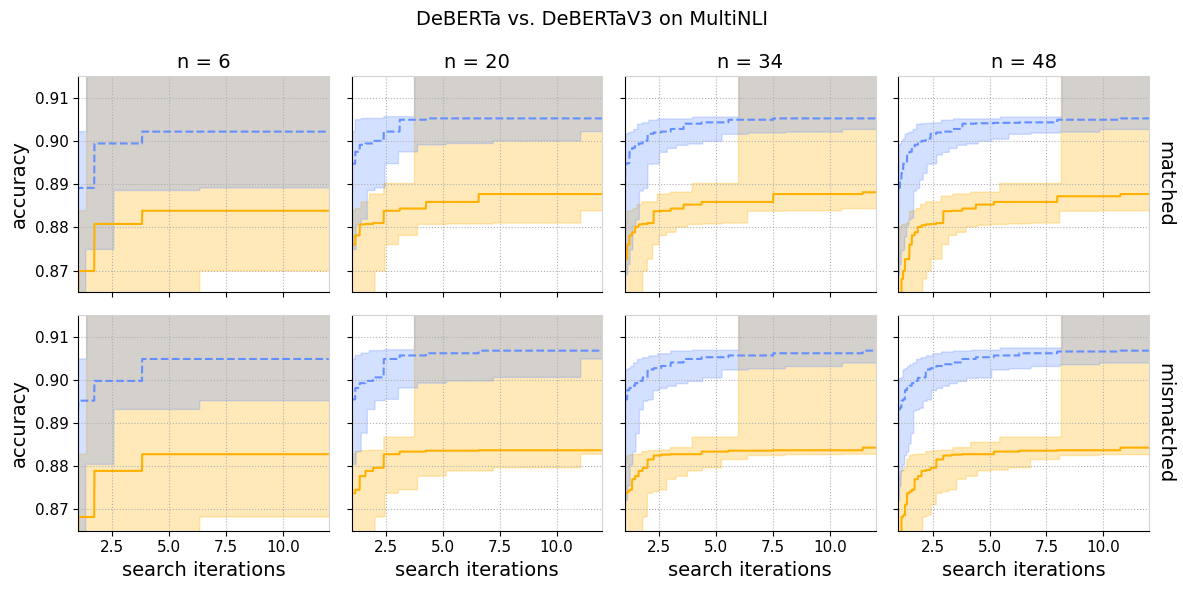

In [6]:
# Choose indices to subsample the data and obtain a sample of size
# sample_size_.
idxs = generator.choice(total_samples, size=n, replace=False)

fig, axes = plt.subplots(
    nrows=2,
    ncols=len(sample_sizes),
    sharex=True,
    sharey="row",
    figsize=(12, 6),
)
for j, sample_size_ in enumerate(sample_sizes):
    for i, evaluation_ in enumerate(evaluations):
        for model_ in models:
            ys = model_to_evaluation_to_ys[model_][evaluation_][
                idxs[:sample_size_]
            ]

            # Construct the confidence bands.
            lower_cdf, point_cdf, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band,
                )

            # Plot the confidence bands.
            axes[i, j].plot(
                ns_grid,
                point_cdf.quantile_tuning_curve(ns_grid),
                label=models[model_]["name"],
                **models[model_]["style"],
            )
            axes[i, j].fill_between(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                lower_cdf.quantile_tuning_curve(ns_grid),
                alpha=0.275,
                color=models[model_]["style"]["color"],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel("search iterations")
    axes[0, j].set_title(f"n = {sample_size_}")

for i, evaluation_ in enumerate(evaluations):
    axes[i, 0].set_ylabel("accuracy")
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(evaluation_, labelpad=18, rotation=270)

for i in range(len(evaluations)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

fig.suptitle("DeBERTa vs. DeBERTaV3 on MultiNLI")

fig.tight_layout()

plt.show()

Similarly to before, our conclusion would've remained largely the same regardless of sample size. The main difference is at what number of search iterations our confidence bands become trivial, and thus for how far we can confidently claim DeBERTaV3 outperforms DeBERTa.